# Resampling:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
import glob
import os

In [2]:
# Load file: SpEC and SACRA have 3 columns, BAM and THC have either 9 or 7 columns:
# ['uoM', 'Real', 'Imag', 'Red', 'Imd', 'Momega', 'AoM', 'phi', 'time']
def load_data(file):
    try:
        df_test = pd.read_csv(file, sep=r'\s+')
        if len(df_test.columns) == 9:
            df = pd.read_csv(file, header=None, names=['time', 'Real', 'Imag', 'Red', 'Imd', 'Momega', 'AoM', 'phi', 't'], sep=r'\s+')
        elif len(df_test.columns) == 7:
            df = pd.read_csv(file, header=None, names=['time', 'Real', 'Imag', 'Momega', 'AoM', 'phi', 't'], sep=r'\s+')
        elif len(df_test.columns) == 3:
            df = pd.read_csv(file, header=None, names=['time', 'Real', 'Imag'], sep=r'\s+')
        else:
            return pd.DataFrame()  # Return an empty DataFrame if no condition matches
        return df
    except Exception as e:
        print(f"Error loading data from {file}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on error

In [3]:
# Resample data on constant time step
def resample_data(df, new_index):
    # Initialize an empty DataFrame with the new time index
    df_resampled = pd.DataFrame(new_index, columns=['time'])
    
    # Ensure 'time' is treated correctly for interpolation
    df.set_index('time', inplace=True)  # Temporarily set 'time' as the index for easier slicing

    # Loop through each column to interpolate
    for column in df.columns:  # Now using all columns except 'time' which is the index
        # Fit the UnivariateSpline to the data, specify k=4 for 4th order spline
        spline = UnivariateSpline(df.index, df[column], k=4, s=0)  # s=0 means no smoothing, exact fit
        # Evaluate the spline at the new time points
        df_resampled[column] = spline(new_index)

    df_resampled.set_index('time', inplace=True)  # Set 'time' back to the index for output consistency

    return df_resampled.reset_index()  # Reset index to get 'time' back as a column

In [4]:
# Save resampled data in new directory
def save_resampled_data(original_file, df_resampled):
    base, fname = os.path.split(original_file)
    new_fname = f"{os.path.splitext(fname)[0]}_resampled.csv"
    save_path = os.path.join(base, new_fname)
    df_resampled.to_csv(save_path, index=False)
    print(f"Saved resampled data to {save_path}")

In [5]:
# Get time bounds for each data at 3 resolutions to ensure the files have equal lengths
def get_global_time_bounds(files):
    min_time = float('inf')
    max_time = float('inf')
    max_time_step = 0
    
    for file in files:
        df = load_data(file)

        current_min = df['time'].min()
        current_max = df['time'].max()
        current_time_step = df['time'].diff().max()  # finding the maximum time difference
        #current_time_step = df['time'].diff().min()  # finding the maximum time difference
        
        if current_min < min_time:
            min_time = current_min
        if current_max < max_time:
            max_time = current_max
        if current_time_step > max_time_step:
            max_time_step = current_time_step
    
    return min_time, max_time, max_time_step

In [6]:
# Establish bounds for Psi4
path_p = 'SACRA/Psi4/*/SACRA_HB_135_135_psi4.txt'
files_p = glob.glob(path_p)

# Determine global time bounds and time step
start_p, end_p, step_p = get_global_time_bounds(files_p)
print('Code bounds Psi4', start_p, end_p, step_p)
# Define time grid based on the min and max time found in both datasets
new_index_psi4 = np.arange(start_p, end_p, step_p)

Code bounds Psi4 0.1858032 15000.078 0.261000000000422


Saved resampled data to SACRA/Psi4/R01/SACRA_HB_135_135_psi4_resampled.csv
Saved resampled data to SACRA/Psi4/R02/SACRA_HB_135_135_psi4_resampled.csv
Saved resampled data to SACRA/Psi4/R03/SACRA_HB_135_135_psi4_resampled.csv


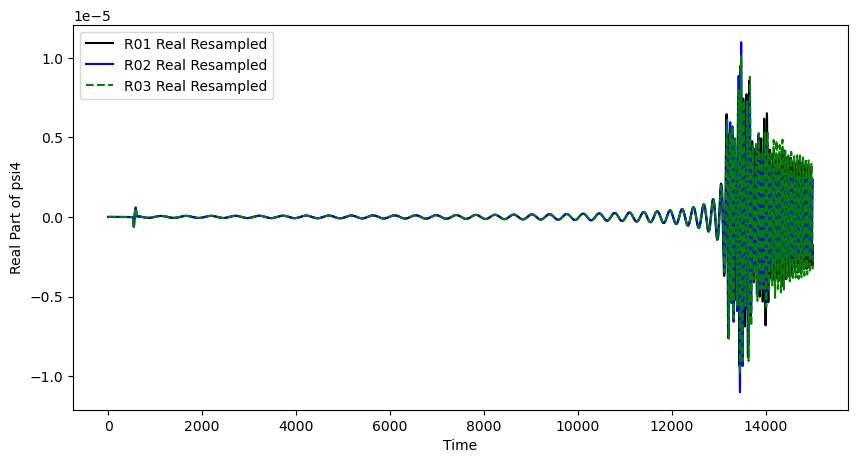

In [7]:
# Load, resample, save and inspect for psi4
file_c_psi4 = 'SACRA/Psi4/R01/SACRA_HB_135_135_psi4.txt'
file_m_psi4 = 'SACRA/Psi4/R02/SACRA_HB_135_135_psi4.txt'
file_f_psi4 = 'SACRA/Psi4/R03/SACRA_HB_135_135_psi4.txt'

df_Fc_psi4 = load_data(file_c_psi4)
df_Fm_psi4 = load_data(file_m_psi4)
df_Ff_psi4 = load_data(file_f_psi4)

# Resample using the refined function
df_Fc_resampled_psi4 = resample_data(df_Fc_psi4, new_index_psi4)
df_Fm_resampled_psi4 = resample_data(df_Fm_psi4, new_index_psi4)
df_Ff_resampled_psi4 = resample_data(df_Ff_psi4, new_index_psi4)

# Save resampled data
save_resampled_data(file_c_psi4, df_Fc_resampled_psi4)
save_resampled_data(file_m_psi4, df_Fm_resampled_psi4)
save_resampled_data(file_f_psi4, df_Ff_resampled_psi4)

# Load and plot the resampled data
resampled_df_Fc_psi4 = pd.read_csv('SACRA/Psi4/R01/SACRA_HB_135_135_psi4_resampled.csv')
resampled_df_Fm_psi4 = pd.read_csv('SACRA/Psi4/R02/SACRA_HB_135_135_psi4_resampled.csv')
resampled_df_Ff_psi4 = pd.read_csv('SACRA/Psi4/R03/SACRA_HB_135_135_psi4_resampled.csv')

plt.figure(figsize=(10, 5))
plt.plot(resampled_df_Fc_psi4['time'], resampled_df_Fc_psi4['Real'], label='R01 Real Resampled', color='black', linestyle='-')
plt.plot(resampled_df_Fm_psi4['time'], resampled_df_Fm_psi4['Real'], label='R02 Real Resampled', color='blue', linestyle='-')
plt.plot(resampled_df_Ff_psi4['time'], resampled_df_Ff_psi4['Real'], label='R03 Real Resampled', color='green', linestyle='--')
#plt.plot(load_data(file_c_psi4)['time'], load_data(file_c_psi4)['Real'], label='R01 Real Original', color='orange', linestyle='-', linewidth=0.5)
#plt.plot(load_data(file_m_psi4)['time'], load_data(file_m_psi4)['Real'], label='R02 Real Original', color='magenta', linestyle='-', linewidth=0.5)
#plt.plot(load_data(file_f_psi4)['time'], load_data(file_f_psi4)['Real'], label='R03 Real Original', color='red', linestyle='-', linewidth=0.5)
#plt.title('Comparison of Resampled Data')
plt.xlabel('Time')
plt.ylabel('Real Part of psi4')
plt.legend()
plt.show()

In [8]:
# Establish bounds for Strain
path_h = 'SACRA/Strain/*/SACRA_HB_135_135_h.txt'
files_h = glob.glob(path_h)

# Determine global time bounds and time step
start_h, end_h, step_h = get_global_time_bounds(files_h)
print('Code bounds Strain', start_h, end_h, step_h)
# Define time grid based on the min and max time found in both datasets
new_index_h = np.arange(start_h, end_h, step_h)

Code bounds Strain -567.35846 14432.534 0.261000000000422


Saved resampled data to SACRA/Strain/R01/SACRA_HB_135_135_h_resampled.csv
Saved resampled data to SACRA/Strain/R02/SACRA_HB_135_135_h_resampled.csv
Saved resampled data to SACRA/Strain/R03/SACRA_HB_135_135_h_resampled.csv


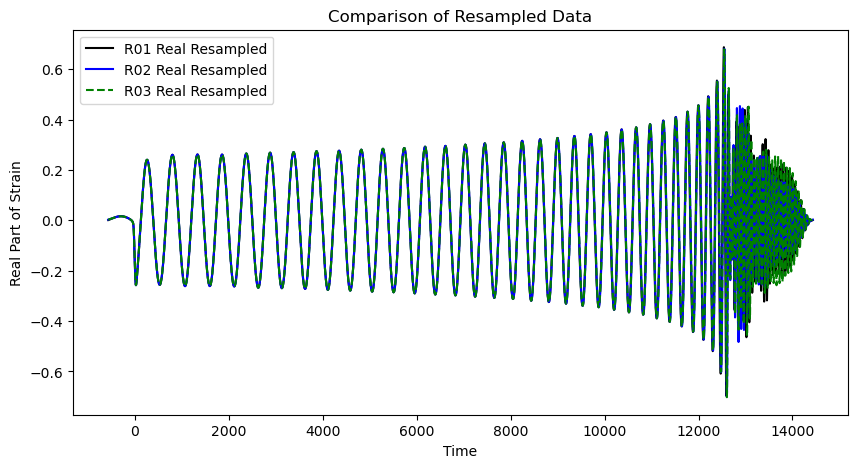

In [9]:
# Load, resample, save and inspect for psi4
file_c_h = 'SACRA/Strain/R01/SACRA_HB_135_135_h.txt'
file_m_h = 'SACRA/Strain/R02/SACRA_HB_135_135_h.txt'
file_f_h = 'SACRA/Strain/R03/SACRA_HB_135_135_h.txt'

df_Fc_h = load_data(file_c_h)
df_Fm_h = load_data(file_m_h)
df_Ff_h = load_data(file_f_h)

# Resample using the refined function
df_Fc_resampled_h = resample_data(df_Fc_h, new_index_h)
df_Fm_resampled_h = resample_data(df_Fm_h, new_index_h)
df_Ff_resampled_h = resample_data(df_Ff_h, new_index_h)

# Save resampled data
save_resampled_data(file_c_h, df_Fc_resampled_h)
save_resampled_data(file_m_h, df_Fm_resampled_h)
save_resampled_data(file_f_h, df_Ff_resampled_h)

# Load and plot the resampled data
resampled_df_Fc_h = pd.read_csv('SACRA/Strain/R01/SACRA_HB_135_135_h_resampled.csv')
resampled_df_Fm_h = pd.read_csv('SACRA/Strain/R02/SACRA_HB_135_135_h_resampled.csv')
resampled_df_Ff_h = pd.read_csv('SACRA/Strain/R03/SACRA_HB_135_135_h_resampled.csv')

plt.figure(figsize=(10, 5))
plt.plot(resampled_df_Fc_h['time'], resampled_df_Fc_h['Real'], label='R01 Real Resampled', color='black', linestyle='-')
plt.plot(resampled_df_Fm_h['time'], resampled_df_Fm_h['Real'], label='R02 Real Resampled', color='blue', linestyle='-')
plt.plot(resampled_df_Ff_h['time'], resampled_df_Ff_h['Real'], label='R03 Real Resampled', color='green', linestyle='--')
#plt.plot(load_data(file_c_h)['time'], load_data(file_c_h)['Real'], label='R01 Real Original', color='orange', linestyle='-', linewidth=0.5)
#plt.plot(load_data(file_m_h)['time'], load_data(file_m_h)['Real'], label='R02 Real Original', color='magenta', linestyle='-', linewidth=0.5)
#plt.plot(load_data(file_f_h)['time'], load_data(file_f_h)['Real'], label='R03 Real Original', color='red', linestyle='-', linewidth=0.5)
plt.title('Comparison of Resampled Data')
plt.xlabel('Time')
plt.ylabel('Real Part of Strain')
plt.legend()
plt.show()